
Running experiment for K=1...
Confusion Matrix:
[[468. 267.]
 [289. 445.]]
Accuracy: 0.6215
Precision: 0.6216
Recall: 0.6215
F1-Score: 0.6214


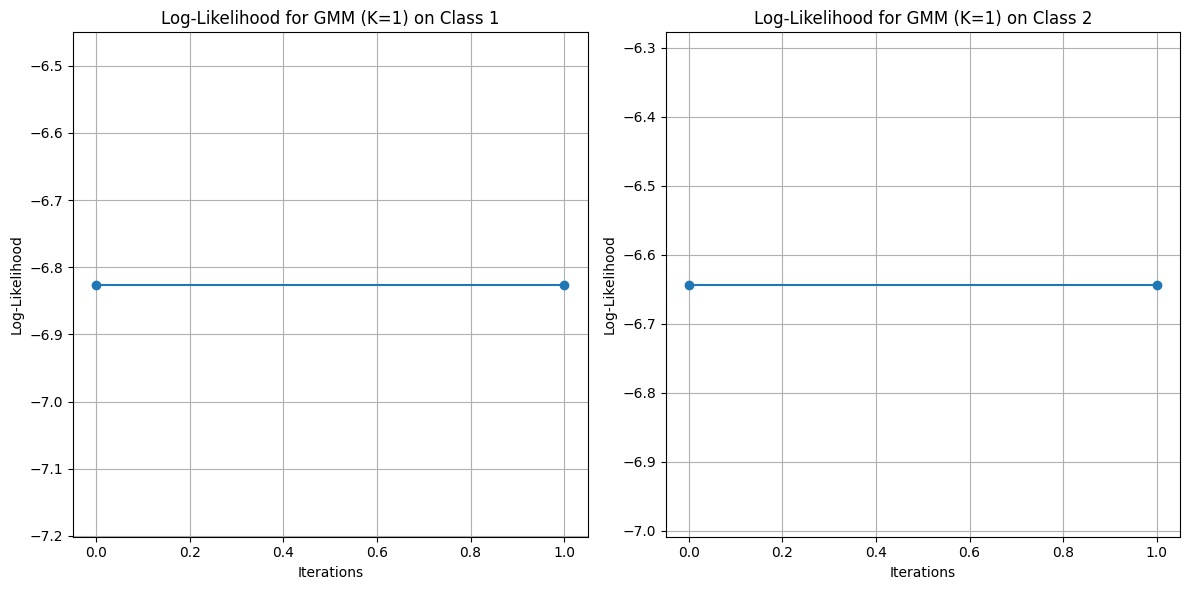

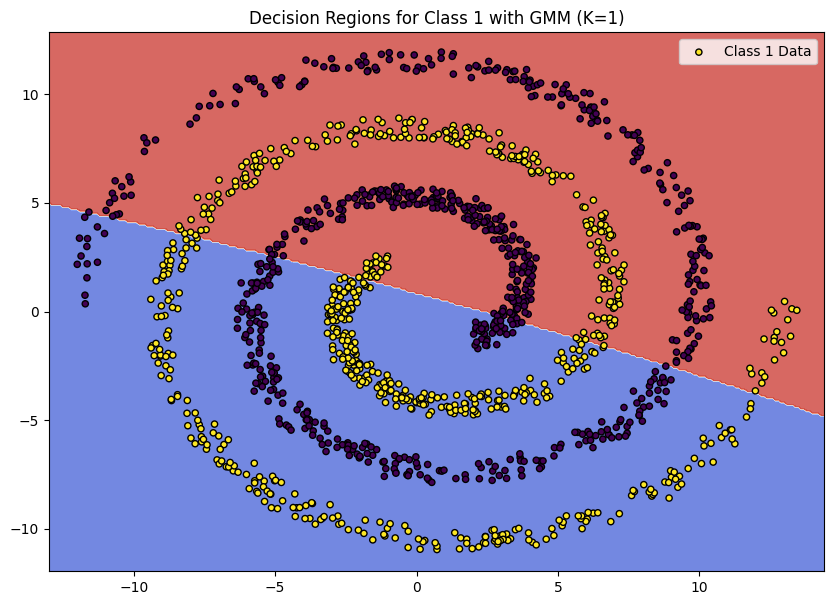

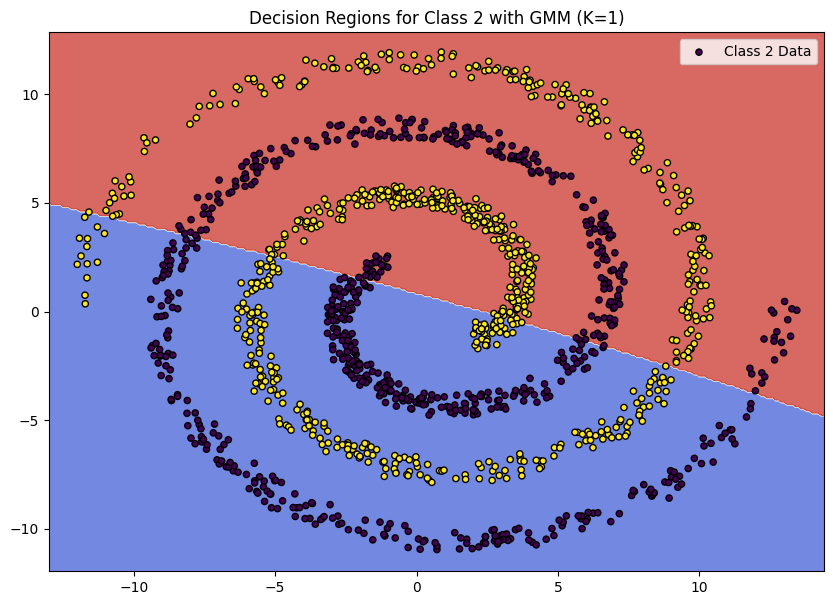


Running experiment for K=2...
Confusion Matrix:
[[441. 294.]
 [249. 485.]]
Accuracy: 0.6304
Precision: 0.6309
Recall: 0.6304
F1-Score: 0.6300


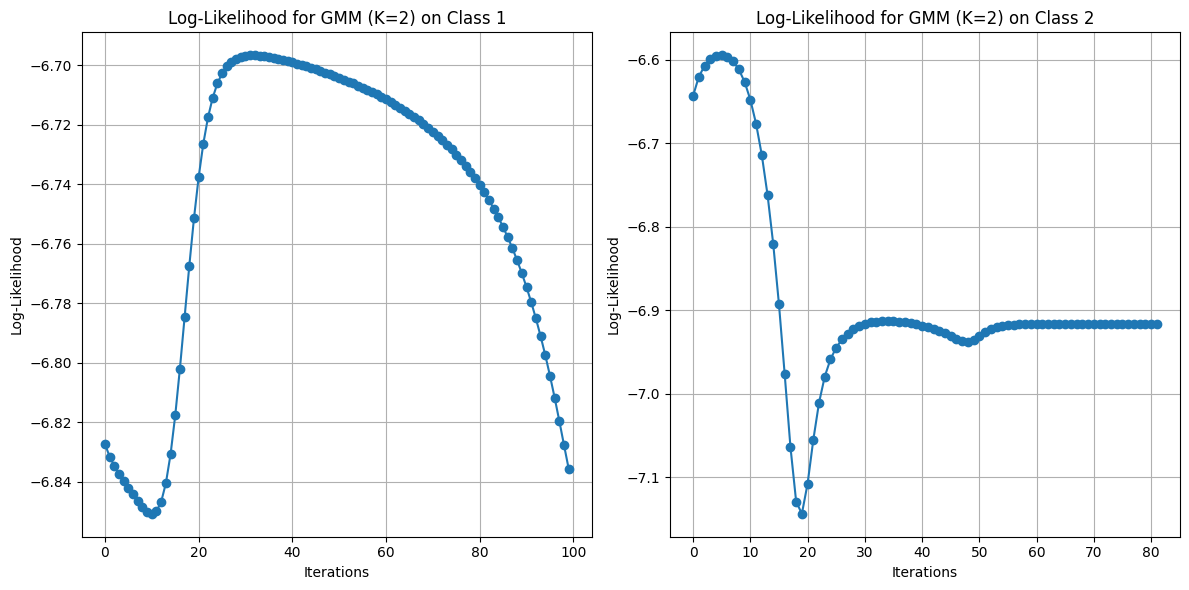

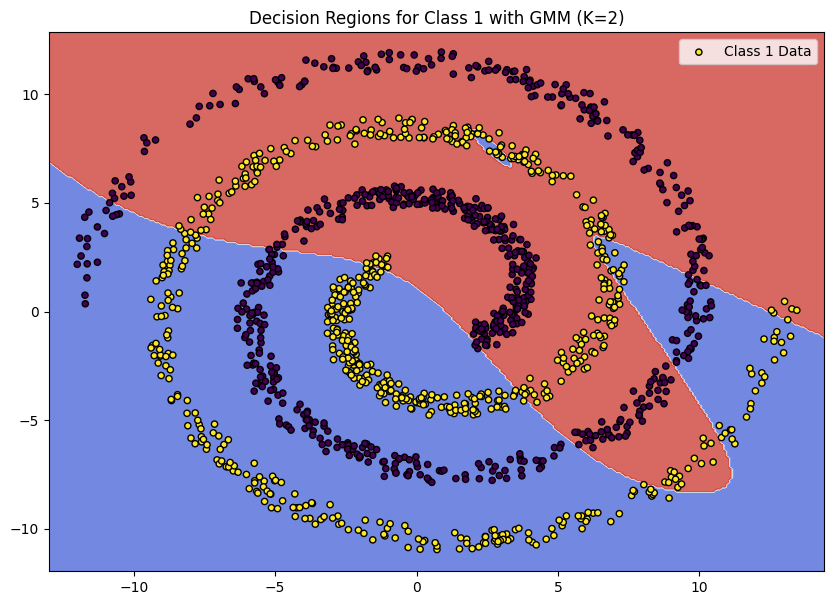

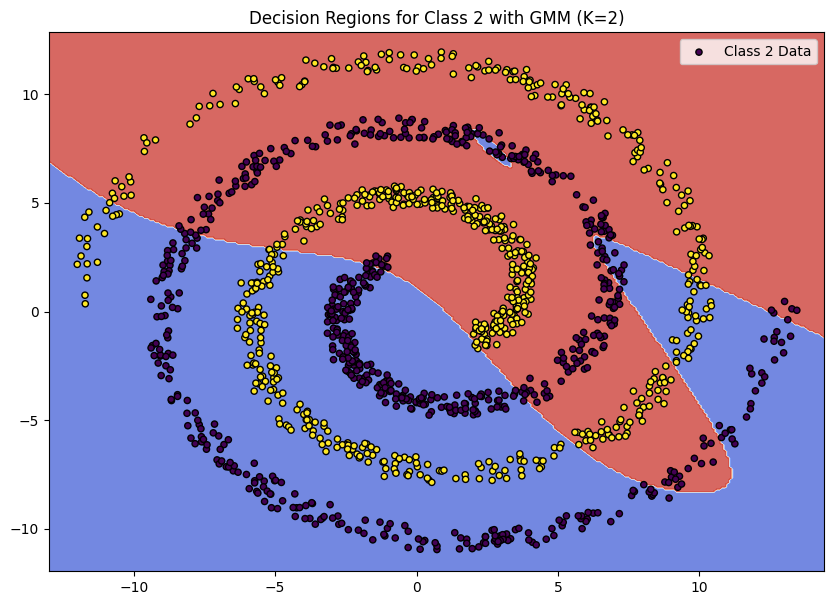


Running experiment for K=4...
Confusion Matrix:
[[597. 138.]
 [ 99. 635.]]
Accuracy: 0.8387
Precision: 0.8396
Recall: 0.8387
F1-Score: 0.8386


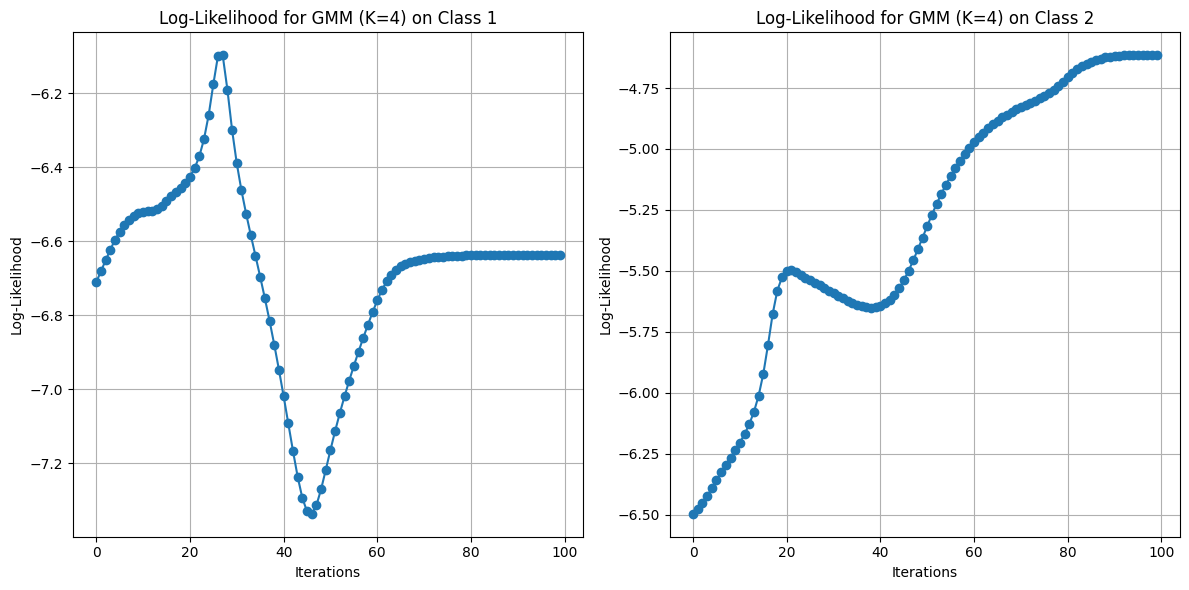

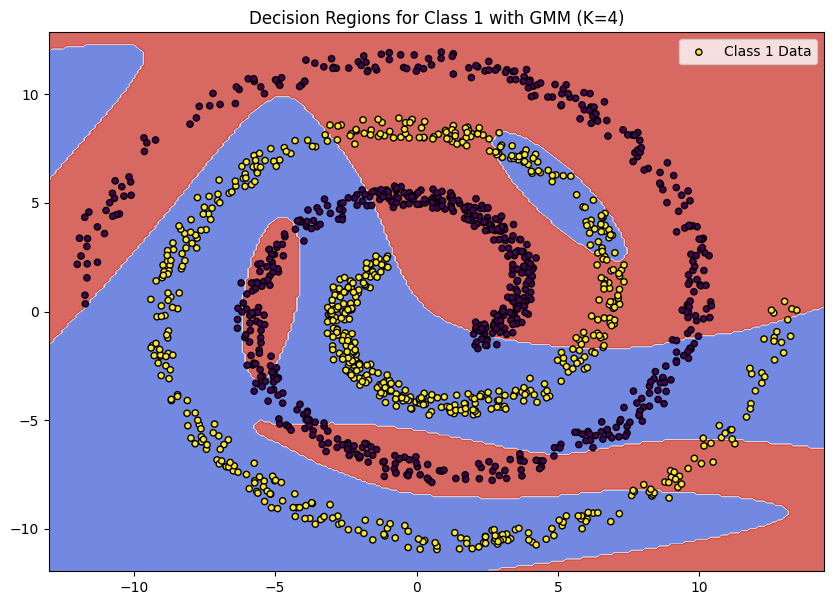

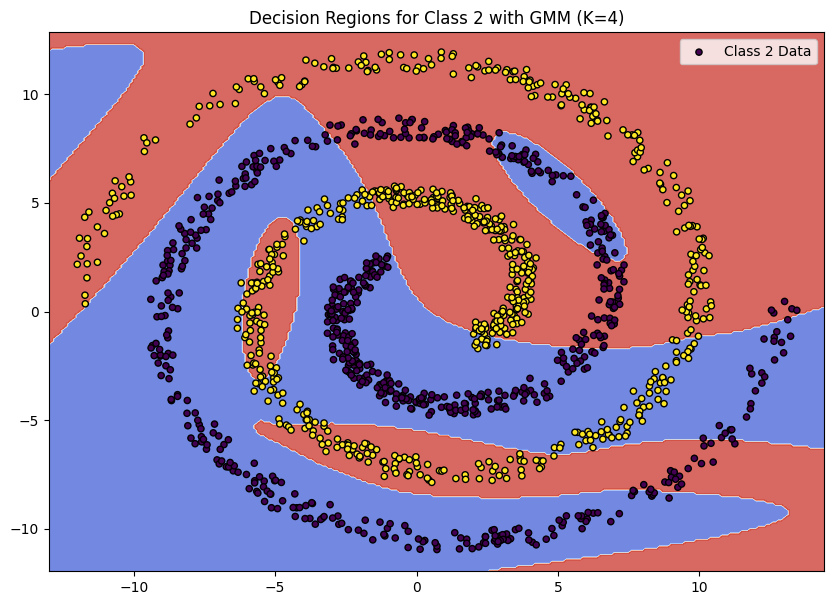


Running experiment for K=8...
Confusion Matrix:
[[729.   6.]
 [  1. 733.]]
Accuracy: 0.9952
Precision: 0.9953
Recall: 0.9952
F1-Score: 0.9952


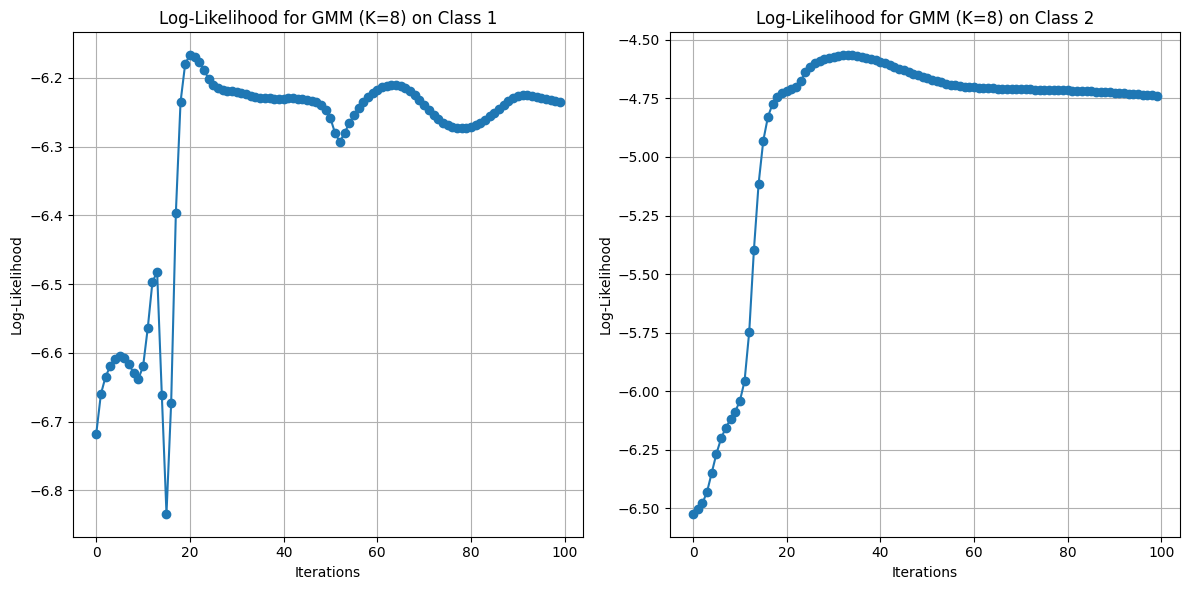

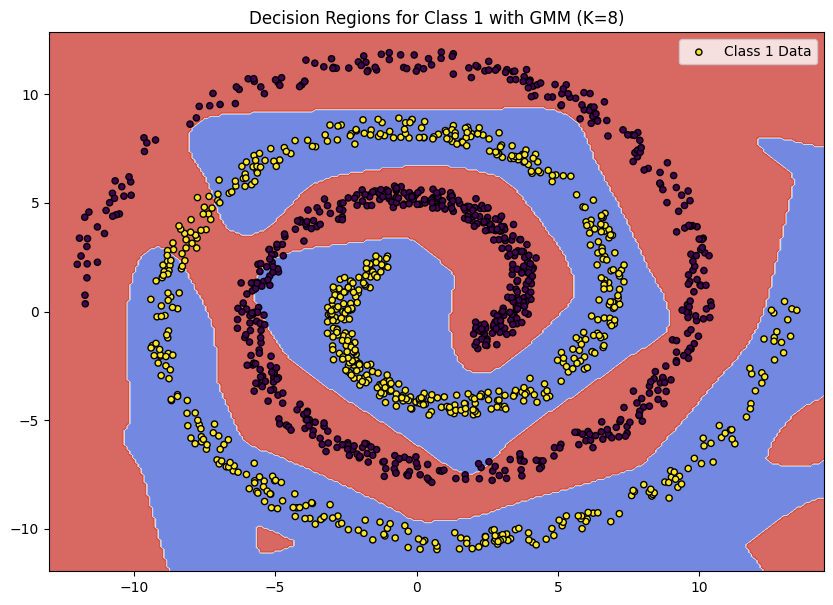

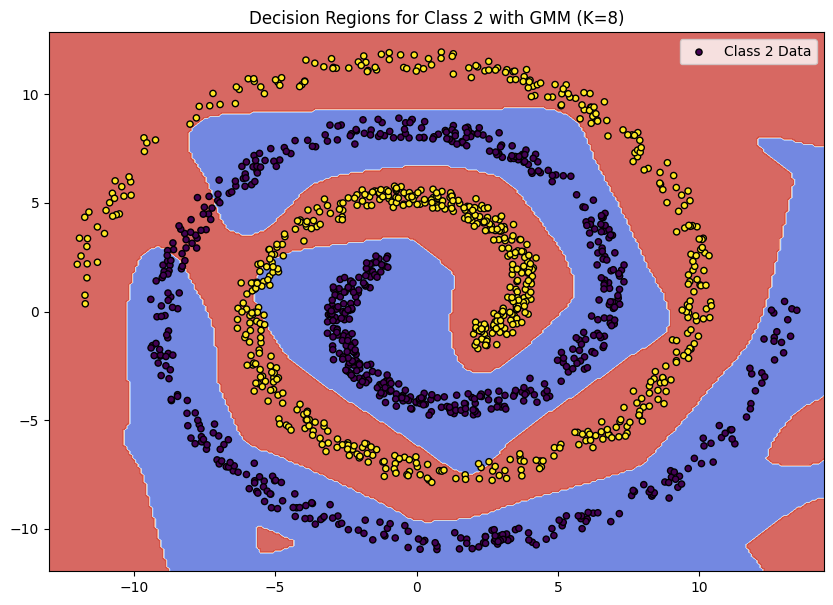


Running experiment for K=16...
Confusion Matrix:
[[735.   0.]
 [  0. 734.]]
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


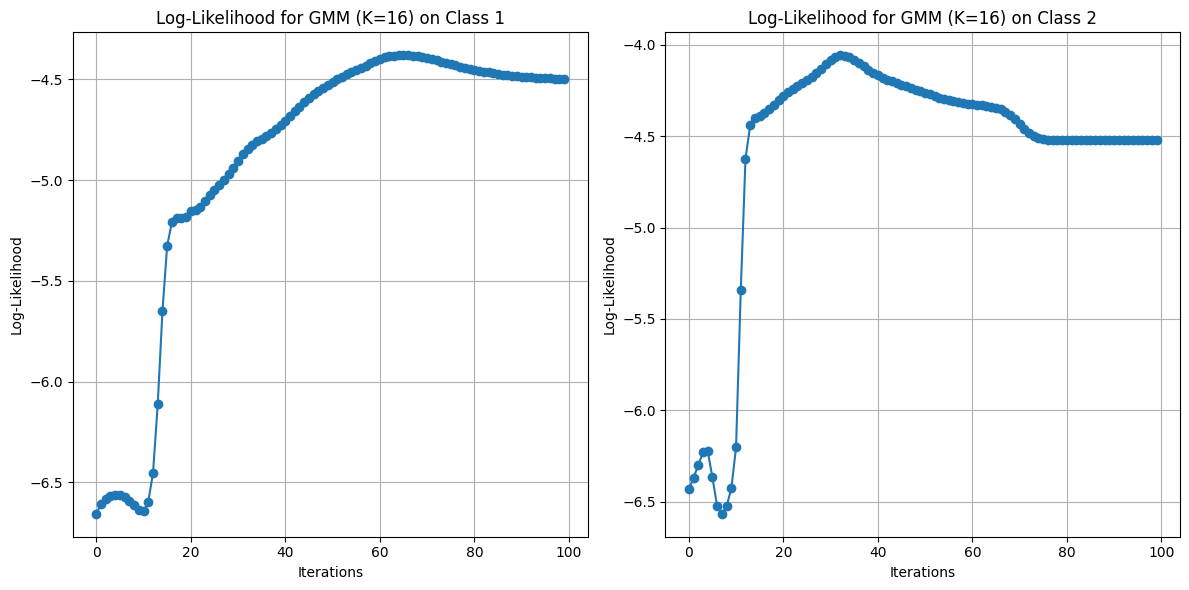

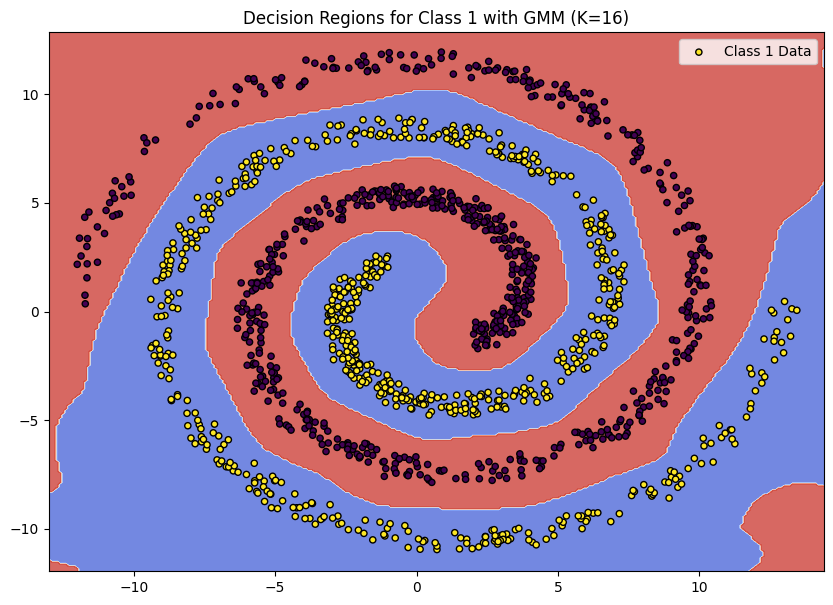

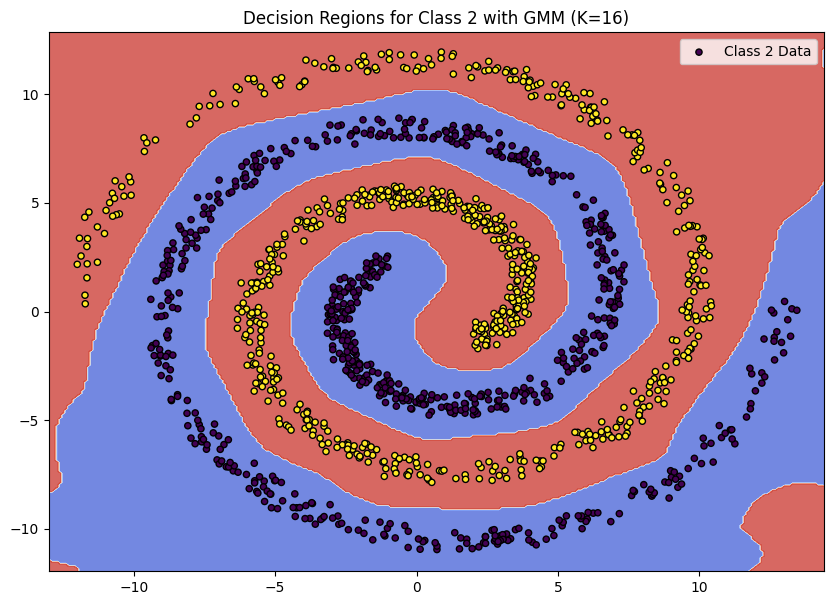


Running experiment for K=32...
Confusion Matrix:
[[735.   0.]
 [  0. 734.]]
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


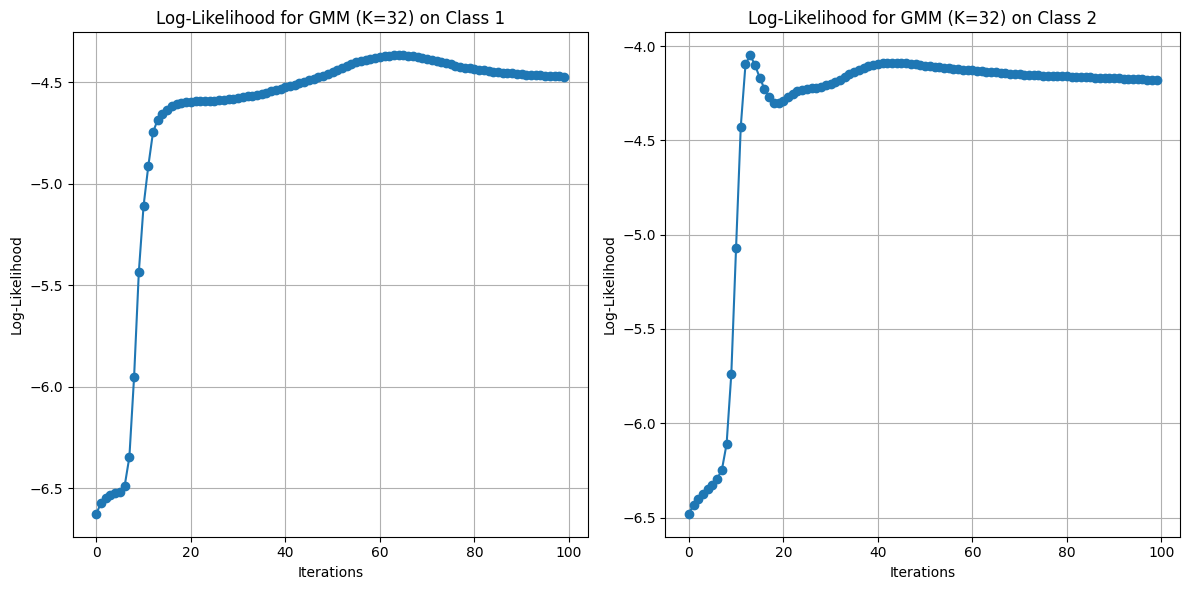

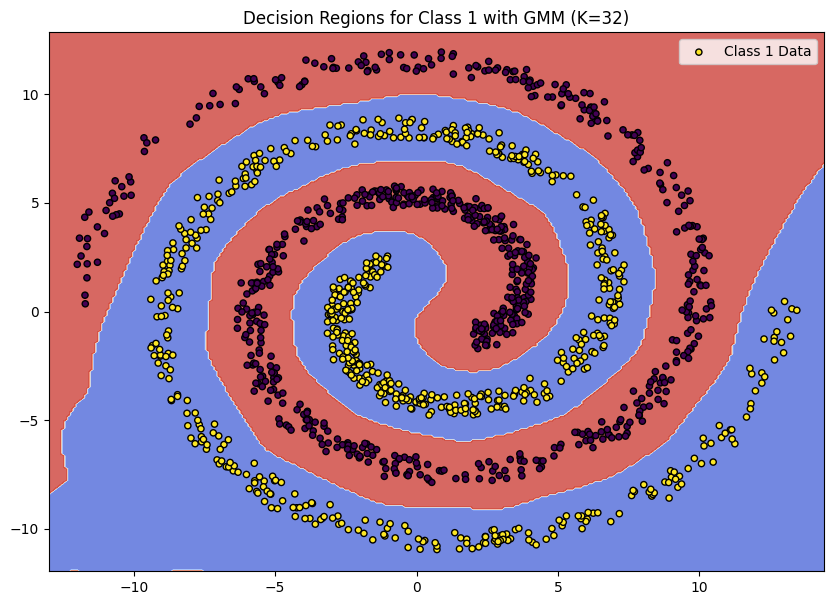

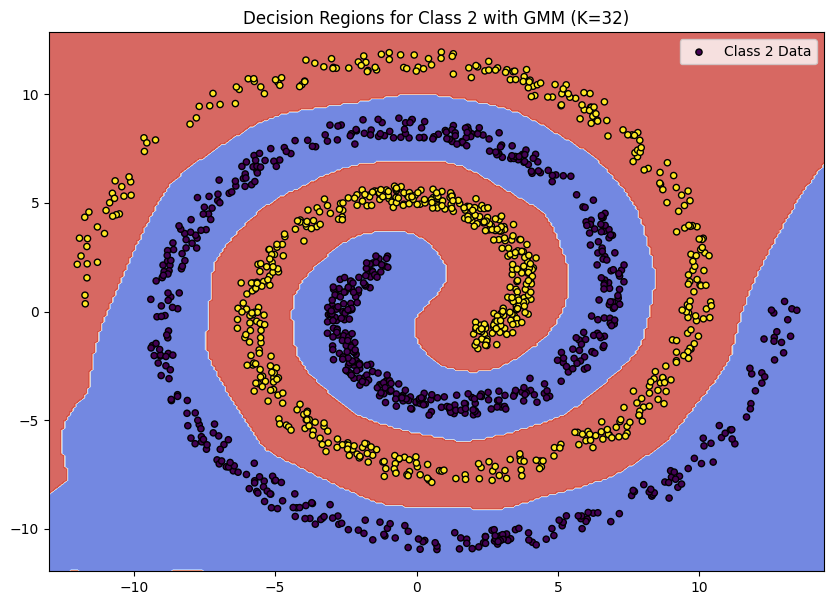

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Function to split data into training and test sets (70% training, 30% test)
def train_test_split(class1_data, class2_data, test_size=0.3):
    n1, n2 = len(class1_data), len(class2_data)
    idx1 = np.random.permutation(n1)
    idx2 = np.random.permutation(n2)
    
    split1 = int(n1 * (1 - test_size))
    split2 = int(n2 * (1 - test_size))
    
    train1, test1 = class1_data[idx1[:split1]], class1_data[idx1[split1:]]
    train2, test2 = class2_data[idx2[:split2]], class2_data[idx2[split2:]]
    
    return train1, test1, train2, test2

# Function to perform K-Means clustering
def kmeans(X, k, max_iters=100):
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        clusters = np.argmin(distances, axis=1)
        new_centroids = np.array([X[clusters == i].mean(axis=0) for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return centroids, clusters

def gaussian_pdf(x, mean, cov, epsilon=1e-5):
    d = len(mean)
    cov += np.eye(d) * epsilon  # Increase regularization to the covariance matrix
    x_m = x - mean
    try:
        return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(cov)))) * \
               np.exp(-0.5 * np.dot(np.dot(x_m.T, np.linalg.inv(cov)), x_m))
    except np.linalg.LinAlgError:
        # If the matrix is still singular, return a small probability
        return 1e-10

# Function to perform GMM with regularization
def gmm(X, k, max_iters=100, tol=1e-6, epsilon=1e-5, init_means=None, init_covariances=None, init_weights=None):
    n, d = X.shape
    if init_means is None:
        init_means = X[np.random.choice(X.shape[0], k, replace=False)]
    if init_covariances is None:
        init_covariances = np.array([np.cov(X.T) + np.eye(d) * epsilon for _ in range(k)])  # Regularize initial covariances
    if init_weights is None:
        init_weights = np.ones(k) / k
        
    means = init_means
    covariances = init_covariances
    weights = init_weights
    log_likelihoods = []

    for _ in range(max_iters):
        # E-Step: Calculate responsibilities
        responsibilities = np.zeros((n, k))
        for i in range(k):
            for j in range(n):
                responsibilities[j, i] = weights[i] * gaussian_pdf(X[j], means[i], covariances[i], epsilon)
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # M-Step: Update parameters
        N_k = responsibilities.sum(axis=0)
        weights = N_k / n
        means = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]
        covariances = np.array([np.dot((responsibilities[:, i][:, np.newaxis] * (X - means[i])).T, (X - means[i])) / N_k[i]
                                for i in range(k)])
        # Regularize the covariance matrices to avoid singularity
        covariances = np.array([cov + np.eye(d) * epsilon for cov in covariances])

        # Compute log-likelihood
        log_likelihood = np.sum(np.log(np.sum([weights[i] * gaussian_pdf(X[j], means[i], covariances[i], epsilon) 
                                               for i in range(k)], axis=0)))
        log_likelihoods.append(log_likelihood)

        # Check for convergence
        if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return means, covariances, weights, responsibilities, log_likelihoods

# Bayes Classifier using GMMs
def bayes_classifier_gmm(train1, train2, test_data, k):
    # Train GMMs for each class
    means1, covariances1, weights1, _, _ = gmm(train1, k)
    means2, covariances2, weights2, _, _ = gmm(train2, k)
    
    # Classify test data
    predictions = []
    for x in test_data:
        prob1 = np.sum([weights1[i] * gaussian_pdf(x, means1[i], covariances1[i]) for i in range(k)])
        prob2 = np.sum([weights2[i] * gaussian_pdf(x, means2[i], covariances2[i]) for i in range(k)])
        predictions.append(0 if prob1 > prob2 else 1)
    return np.array(predictions)

# Function to evaluate performance (Precision, Recall, F1, Confusion Matrix)
def evaluate_performance(y_true, y_pred):
    n_classes = len(np.unique(y_true))
    cm = np.zeros((n_classes, n_classes))
    
    for i in range(len(y_true)):
        cm[int(y_true[i]), int(y_pred[i])] += 1
    
    accuracy = np.trace(cm) / np.sum(cm)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f1 = 2 * precision * recall / (precision + recall)
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {np.nanmean(precision):.4f}")
    print(f"Recall: {np.nanmean(recall):.4f}")
    print(f"F1-Score: {np.nanmean(f1):.4f}")
    
    return cm, accuracy, precision, recall, f1


# Function to plot log-likelihoods for each class
def plot_log_likelihoods_for_classes(log_likelihoods_class1, log_likelihoods_class2, title1, title2):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(log_likelihoods_class1, marker='o')
    plt.title(title1)
    plt.xlabel('Iterations')
    plt.ylabel('Log-Likelihood')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(log_likelihoods_class2, marker='o')
    plt.title(title2)
    plt.xlabel('Iterations')
    plt.ylabel('Log-Likelihood')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Function to plot decision regions for both classes separately
def plot_decision_regions_separate(X, y, gmm1, gmm2, k):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    # Get the predictions for the entire grid
    Z = bayes_classifier_gmm(gmm1, gmm2, np.c_[xx.ravel(), yy.ravel()], k)
    Z = Z.reshape(xx.shape)
    
    # Plot decision regions for class 1
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=(y == 0), edgecolor='k', s=20, label='Class 1 Data')
    plt.title(f'Decision Regions for Class 1 with GMM (K={k})')
    plt.legend()
    plt.show()
    
    # Plot decision regions for class 2
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=(y == 1), edgecolor='k', s=20, label='Class 2 Data')
    plt.title(f'Decision Regions for Class 2 with GMM (K={k})')
    plt.legend()
    plt.show()

# Function to plot decision regions and training data
def plot_decision_regions(X, y, gmm1, gmm2, k):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    Z = bayes_classifier_gmm(gmm1, gmm2, np.c_[xx.ravel(), yy.ravel()], k)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20)
    plt.title(f'Decision Regions with GMM (K={k})')
    plt.show()

# Main execution
with open('NLS_Group03.txt', 'r') as f:
    lines = f.readlines()

lines = lines[1:]  # Assuming the first line is a header
class1_data = []
class2_data = []

for i, line in enumerate(lines):
    if i <= 2446:  # Class 1
        class1_data.append(line.strip().split())
    else:  # Class 2
        class2_data.append(line.strip().split())

# Convert to NumPy arrays
class1_data = np.array(class1_data, dtype=float)
class2_data = np.array(class2_data, dtype=float)

# Split data into training and test sets (70% training, 30% test)
train1, test1, train2, test2 = train_test_split(class1_data, class2_data)

# Run experiments with different numbers of mixtures for GMM
K_values = [1, 2, 4, 8, 16, 32]
for k in K_values:
    print(f"\nRunning experiment for K={k}...")
    
    # Run Bayes Classifier using GMM for classification
    test_data = np.vstack((test1, test2))
    y_true = np.array([0] * len(test1) + [1] * len(test2))
    y_pred = bayes_classifier_gmm(train1, train2, test_data, k)
    
    # Evaluate performance
    cm, accuracy, precision, recall, f1 = evaluate_performance(y_true, y_pred)
    
    # Plot log-likelihood for GMM training for both classes
    _, _, _, _, log_likelihoods1 = gmm(train1, k)
    _, _, _, _, log_likelihoods2 = gmm(train2, k)
    plot_log_likelihoods_for_classes(log_likelihoods1, log_likelihoods2, f'Log-Likelihood for GMM (K={k}) on Class 1', f'Log-Likelihood for GMM (K={k}) on Class 2')
    
    # Plot decision regions separately for each class
    plot_decision_regions_separate(test_data, y_true, train1, train2, k)


Data Splitting: train_test_split splits the data into 70% training and 30% test sets.
GMM Initialization: K-Means is used to initialize GMM parameters (means, covariances, and weights).
Bayes Classifier: The classifier trains a GMM for each class and classifies test points based on posterior probabilities.
Evaluation: After classification, precision, recall, and F1-score are computed along with the confusion matrix.
Plots:
Log-Likelihood Plot: Plots how log-likelihood changes during GMM training.
Decision Region Plot: Shows decision boundaries based on GMM classifiers.

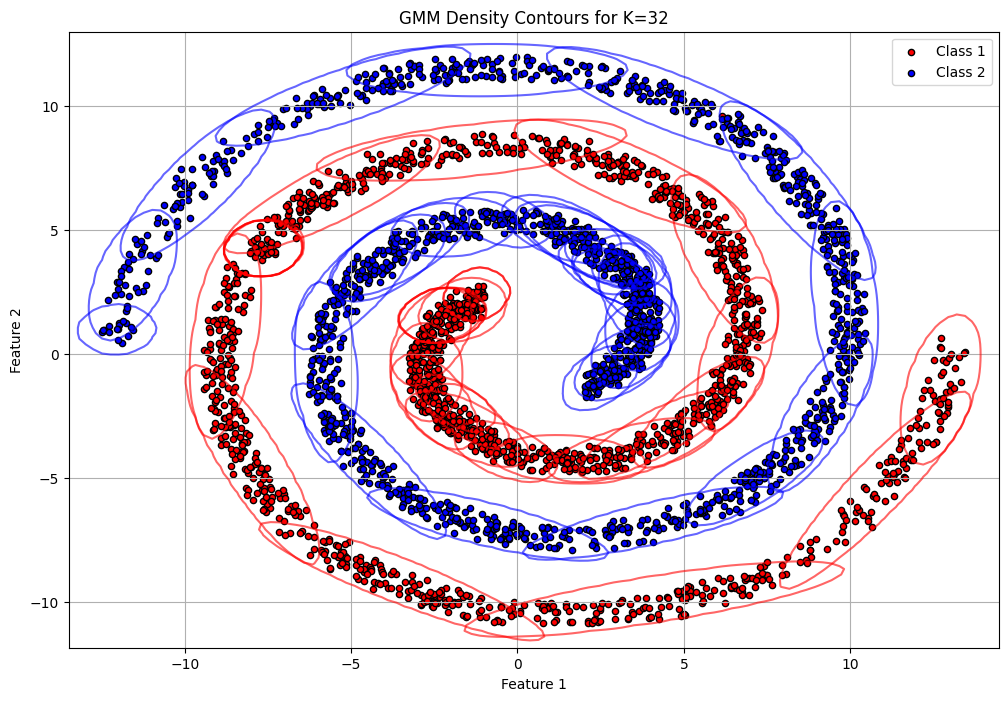

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gmm_density_contours(train_data, gmm_params, k, resolution=100):
    """
    Plots the constant density contour for all classes with the training data superimposed.
    
    Parameters:
    - train_data: List of training data arrays for each class.
    - gmm_params: List of GMM parameters (means, covariances, weights) for each class.
    - k: Number of GMM components for each class.
    - resolution: Grid resolution for contour plotting.
    """
    # Create a color map for plotting
    colors = ['red', 'blue', 'green', 'purple']
    
    plt.figure(figsize=(12, 8))

    # Plot the density contours for each class
    for class_idx, (class_train_data, (means, covariances, weights)) in enumerate(zip(train_data, gmm_params)):
        # Plot the training data points for the current class
        plt.scatter(class_train_data[:, 0], class_train_data[:, 1], s=20, color=colors[class_idx % len(colors)], label=f'Class {class_idx + 1}', edgecolor='k')

        # Plot the Gaussian contours for each component
        for i in range(k):
            mean = means[i]
            cov = covariances[i]

            # Create a grid of points
            x_min, x_max = class_train_data[:, 0].min() - 1, class_train_data[:, 0].max() + 1
            y_min, y_max = class_train_data[:, 1].min() - 1, class_train_data[:, 1].max() + 1
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))

            # Calculate the density values for the grid
            zz = np.array([gaussian_pdf(np.array([x, y]), mean, cov) for x, y in zip(np.ravel(xx), np.ravel(yy))])
            zz = zz.reshape(xx.shape)

            # Plot the contour for the current Gaussian component
            plt.contour(xx, yy, zz, levels=[0.01], colors=colors[class_idx % len(colors)], alpha=0.6)

    plt.title(f'GMM Density Contours for K={k}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
# Train GMMs for each class and store parameters
k = 32  # Set the number of components
gmm_params = []
for class_train in [train1, train2]:
    means, covariances, weights, _, _ = gmm(class_train, k)
    gmm_params.append((means, covariances, weights))

# Plot GMM density contours with training data for each class
plot_gmm_density_contours([train1, train2], gmm_params, k)


In [5]:
import numpy as np

def calculate_metrics(conf_matrix):
    # Calculate the number of classes from the confusion matrix
    n_classes = conf_matrix.shape[0]
    
    # Initialize arrays to store precision, recall, and F-measure for each class
    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    f_measure = np.zeros(n_classes)

    # Calculate precision, recall, and F-measure for each class
    for i in range(n_classes):
        true_positive = conf_matrix[i, i]
        false_positive = sum(conf_matrix[:, i]) - true_positive
        false_negative = sum(conf_matrix[i, :]) - true_positive
        
        # Precision calculation
        precision[i] = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        
        # Recall calculation
        recall[i] = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        
        # F-measure calculation
        f_measure[i] = (2 * precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

    # Calculate overall accuracy
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    
    # Calculate mean precision, recall, and F-measure
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f_measure = np.mean(f_measure)

    # Return all calculated metrics
    return accuracy, precision, recall, f_measure, mean_precision, mean_recall, mean_f_measure

def display_results(conf_matrix, accuracy, precision, recall, f_measure, mean_precision, mean_recall, mean_f_measure):
    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nMetrics for each class:")
    for i in range(len(precision)):
        print(f"Class {i + 1}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F-Measure: {f_measure[i]:.4f}")
    
    # Print the overall metrics
    print("\nOverall Metrics:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F-Measure: {mean_f_measure:.4f}")

# Example usage with a sample confusion matrix
conf_matrix = np.array([[585, 3, 9],
                        [0, 584, 38],
                        [0, 185, 429]])

# Calculate metrics
accuracy, precision, recall, f_measure, mean_precision, mean_recall, mean_f_measure = calculate_metrics(conf_matrix)

# Display results
display_results(conf_matrix, accuracy, precision, recall, f_measure, mean_precision, mean_recall, mean_f_measure)


Confusion Matrix:
[[585   3   9]
 [  0 584  38]
 [  0 185 429]]

Metrics for each class:
Class 1:
  Precision: 1.0000
  Recall: 0.9799
  F-Measure: 0.9898
Class 2:
  Precision: 0.7565
  Recall: 0.9389
  F-Measure: 0.8379
Class 3:
  Precision: 0.9013
  Recall: 0.6987
  F-Measure: 0.7872

Overall Metrics:
Accuracy: 87.18%
Mean Precision: 0.8859
Mean Recall: 0.8725
Mean F-Measure: 0.8716
